In [48]:
import mne
import numpy as np
import pandas as pd
import neurokit2 as nk
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy as sp

<Figure size 1600x1000 with 0 Axes>

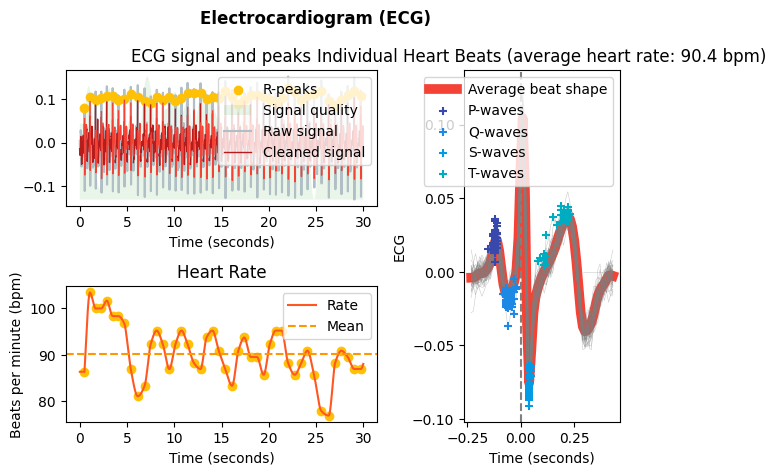

In [4]:
# Load data
data = nk.data("bio_resting_5min_100hz")

# Process ECG
ecg_signals, info = nk.ecg_process(data["ECG"], sampling_rate=100)

# Increase figure size and apply tight layout
plt.figure(figsize=(16, 10))  # Adjust width and height as needed
nk.ecg_plot(ecg_signals[:3000], info)
plt.subplots_adjust(hspace=0.6, wspace=0.4)
plt.tight_layout()  # Prevent overlapping
plt.show()

In [5]:
nk.ecg_intervalrelated(ecg_signals)

,ECG_Rate_Mean,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,86.392105,[[69.47563805104409]],[[4.903604322104105]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],[[3.8837766323814966]],...,[[1.9786368425578704]],[[4.256941017033136]],[[1.2686943754499123]],[[1.404137826745609]],[[1.469801247099329]],[[2.572679544052144]],[[1.562676080749381]],[[1.8465069301766717]],[[2.7223482404936066]],[[0.8731238852455482]]


In [6]:
epochs = nk.epochs_create(ecg_signals,
                          events=[0, 15000],
                          sampling_rate=100,
                          epochs_start=0,
                          epochs_end=150)
# Analyze
nk.ecg_intervalrelated(epochs)

,Label,ECG_Rate_Mean,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
1,1,86.389814,[[69.49767441860465]],[[5.167181138835641]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],...,[[1.2527629684953678]],[[4.290505175709077]],[[1.1667625041387146]],[[1.3234302834078784]],[[1.3340298186240032]],[[1.5730504365078102]],[[1.6535777692661096]],[[1.8035044265520663]],[[2.336829556302458]],[[0.8288764443746864]]
2,2,86.394396,[[69.46046511627907]],[[4.648089725942579]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],...,[[1.8817856208857746]],[[4.080221616903997]],[[1.3473463161429124]],[[1.7371494891482802]],[[1.4976794053994398]],[[1.9578060920316949]],[[1.5369379755191364]],[[1.8952794259141006]],[[3.094110204759245]],[[0.9730288694833277]]


In [9]:
df = pd.read_parquet("data/subj1.parquet")

# Display the first few rows
df.head()

,EEG Fpz-Cz_1,EEG Pz-Oz_1,EOG horizontal_1,EMG Submental_1,Hyp_1
0,-0.000018,0.000007,0.000028,4.002038,0.0
1,-0.000013,0.000002,0.000014,4.003099,0.0
2,0.000005,-0.000005,0.000029,4.004188,0.0
3,-0.000006,-0.000008,0.000014,4.005303,0.0
4,0.000002,-0.000006,0.000020,4.006445,0.0


In [10]:
# Extract EEG signals (ensure they exist in your dataset)
eeg_data = df[["EEG Fpz-Cz_1", "EEG Pz-Oz_1"]].to_numpy().T  # Convert to NumPy array (transpose for MNE format)

# Create MNE Info object
sfreq = 100  # Set your sampling rate (change if different)
ch_names = ["EEG Fpz-Cz_1", "EEG Pz-Oz_1"]
ch_types = ["eeg", "eeg"]

info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# Create MNE RawArray object
raw_eeg = mne.io.RawArray(eeg_data, info)

Creating RawArray with float64 data, n_channels=2, n_times=3227999
    Range : 0 ... 3227998 =      0.000 ... 32279.980 secs
Ready.


c:\Users\Shadow\AppData\Local\Programs\Python\Python313\Lib\site-packages\neurokit2\eeg\eeg_badchannels.py:127: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right")


Bad Channels Detected: []


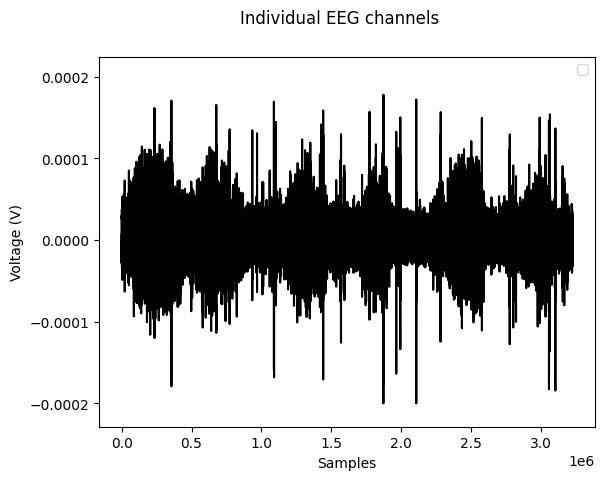

In [11]:
# Detect bad channels
bads, info = nk.eeg_badchannels(raw_eeg, distance_threshold=0.95, show=True)

# Print the detected bad channels
print("Bad Channels Detected:", bads)


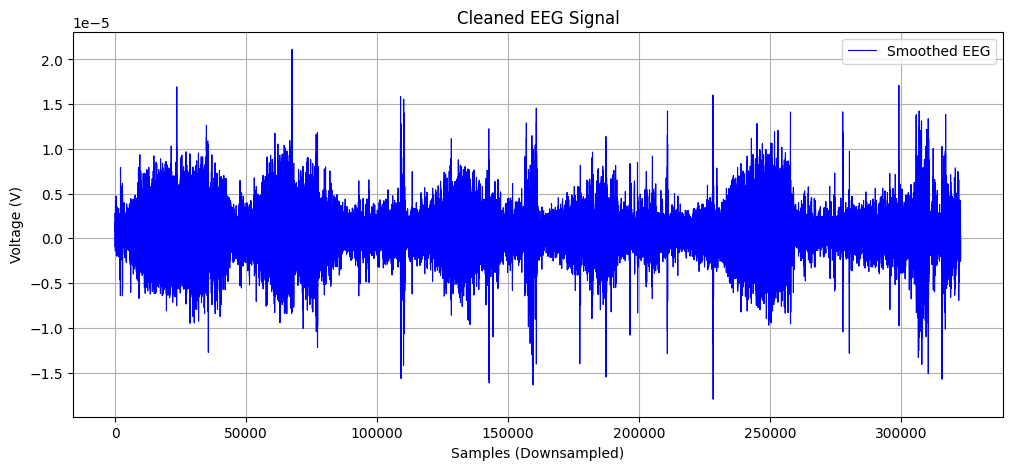

In [12]:
# Extract EEG signal (assuming you have a raw EEG object)
eeg_signal = raw_eeg.get_data()[0]  # Extract first channel

# Downsample the signal (reduce number of points for a cleaner plot)
downsample_factor = 10  # Adjust this for smoother plots
eeg_downsampled = eeg_signal[::downsample_factor]

# Apply a simple moving average filter to smooth the signal
window_size = 50  # Adjust for smoothness
eeg_smoothed = np.convolve(eeg_downsampled, np.ones(window_size)/window_size, mode='valid')

# Plot the cleaned EEG signal
plt.figure(figsize=(12, 5))
plt.plot(eeg_smoothed, color="blue", linewidth=0.8, label="Smoothed EEG")
plt.xlabel("Samples (Downsampled)")
plt.ylabel("Voltage (V)")
plt.title("Cleaned EEG Signal")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# Compute EEG power using Welch's method
eeg_power = nk.eeg_power(raw_eeg, sampling_rate=100, method="welch")

# Extract specific power bands
delta_power = np.mean(eeg_power["Delta"])
theta_power = np.mean(eeg_power["Theta"])
alpha_power = np.mean(eeg_power["Alpha"])
beta_power = np.mean(eeg_power["Beta"])

# Print power values
print(f"Delta Power: {delta_power}")
print(f"Theta Power: {theta_power}")
print(f"Alpha Power: {alpha_power}")
print(f"Beta Power: {beta_power}")


Delta Power: 0.012788401466455728
Theta Power: 0.002333829364701924
Alpha Power: 0.0008504858920539121
Beta Power: 0.0004761277152017659


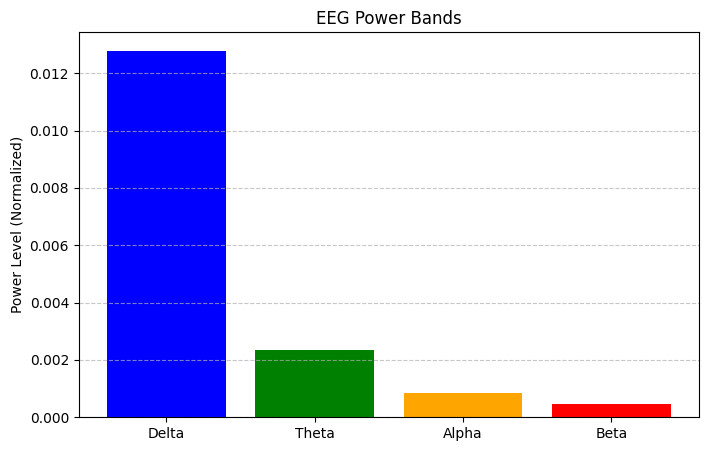

In [ ]:
# Define bands and values
bands = ["Delta", "Theta", "Alpha", "Beta"]
power_values = [delta_power, theta_power, alpha_power, beta_power]

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(bands, power_values, color=["blue", "green", "orange", "red"])
plt.ylabel("Power Level (Normalized)")
plt.title("EEG Power Bands")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [15]:
# Define epoch length (30s)
epoch_length = 30  # seconds
sampling_rate = 100  # Adjust based on your data
samples_per_epoch = epoch_length * sampling_rate

# Convert MNE Raw object to DataFrame
eeg_df = pd.DataFrame(raw_eeg.get_data().T, columns=raw_eeg.ch_names)  # Transpose to match timepoints

# Convert EEG DataFrame columns to numeric (force conversion)
eeg_df = eeg_df.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values (if needed)
eeg_df.dropna(inplace=True)

# OR: Fill NaN values with zero (if drop is not possible)
eeg_df.fillna(0, inplace=True)

# Ensure all epochs contain numerical values
for epoch in epochs.keys():
    epochs[epoch] = epochs[epoch].apply(pd.to_numeric, errors='coerce')

# Convert EEG data from volts (V) to microvolts (µV) for proper scaling
eeg_df *= 1e6  # Now in microvolts

# Generate event onsets at fixed intervals (every 30s)
event_onsets = np.arange(0, len(eeg_df), samples_per_epoch)

# Create epochs
epochs = nk.epochs_create(eeg_df, events=event_onsets, sampling_rate=sampling_rate)

# Convert epochs to DataFrame for inspection
eeg_epochs_df = nk.epochs_to_df(epochs)

print(eeg_epochs_df.head())

   EEG Fpz-Cz_1  EEG Pz-Oz_1  Index Label      Time
0    -18.490410     6.842756      0     1  0.000000
1    -12.687343     1.935454      1     1  0.010003
2      4.830030    -4.646464      2     1  0.020007
3     -6.171618    -7.787137      3     1  0.030010
4      2.488441    -5.824216      4     1  0.040013


In [16]:
# Define your EEG channel names (adjust if needed)
eeg_channels = ["EEG Fpz-Cz_1", "EEG Pz-Oz_1"]

# Create a list to store power values for each epoch.
epoch_power_features = []

# Iterate over epochs in numerical order (convert keys to int for proper sorting)
for key in sorted(epochs.keys(), key=int):
    epoch_data = epochs[key]

    # Select only the EEG channels (this will drop extra columns like "Index", "Label", "Time", etc.)
    try:
        epoch_eeg = epoch_data[eeg_channels]
    except KeyError:
        print(f"Epoch {key}: one or more EEG channel(s) missing.")
        continue

    # Convert the EEG data to numeric (force conversion in case some values are strings)
    epoch_eeg = epoch_eeg.apply(pd.to_numeric, errors='coerce')
    # Drop any rows with NaN values
    epoch_eeg = epoch_eeg.dropna()

    # If after cleaning the epoch is empty, skip it
    if epoch_eeg.empty:
        print(f"Epoch {key} is empty after cleaning; skipping.")
        continue

    # Now compute EEG power using Welch's method
    try:
        power_bands = nk.eeg_power(epoch_eeg, sampling_rate=sampling_rate, method="welch")
    except Exception as e:
        print(f"Epoch {key}: error computing EEG power: {e}")
        continue

    # Check if the expected key "Hz_1_4" (Delta) is in the result
    if "Hz_1_4" not in power_bands:
        print(f"Epoch {key}: power_bands keys are {list(power_bands.keys())}, skipping this epoch.")
        continue

    # Map the returned keys to standard EEG bands
    epoch_features = {
        "Epoch": key,
        "Delta": np.mean(power_bands["Hz_1_4"]),
        "Theta": np.mean(power_bands["Hz_4_8"]),
        "Alpha": np.mean(power_bands["Hz_8_13"]),
        "Beta": np.mean(power_bands["Hz_13_30"]),
        "Gamma": np.mean(power_bands.get("Hz_30_80", [np.nan])),  # Optional Gamma band
    }
    epoch_power_features.append(epoch_features)

# Convert the list of epoch features into a DataFrame
eeg_epoch_power_df = pd.DataFrame(epoch_power_features)

# Print the first few rows of the resulting DataFrame
print(eeg_epoch_power_df.head())


  Epoch     Delta     Theta     Alpha      Beta     Gamma
0     1  0.178851  0.556169  0.316026  0.048283  0.023247
1     2  0.143499  0.311799  0.165421  0.046112  0.042361
2     3  0.085178  0.397235  0.166785  0.035458  0.012592
3     4  0.113562  0.429030  0.187841  0.036416  0.012837
4     5  0.137373  0.569296  0.286778  0.059488  0.018182


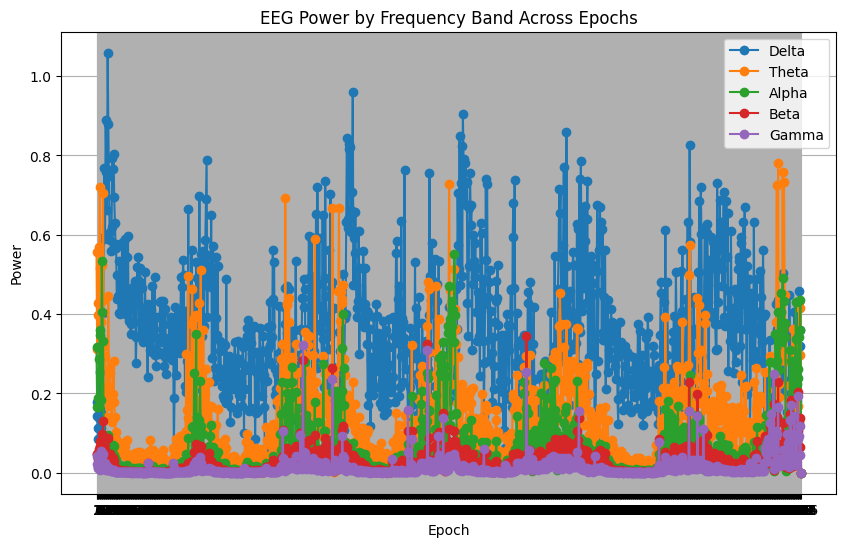

In [17]:
plt.figure(figsize=(10,6))
plt.plot(eeg_epoch_power_df["Epoch"], eeg_epoch_power_df["Delta"], label="Delta", marker="o")
plt.plot(eeg_epoch_power_df["Epoch"], eeg_epoch_power_df["Theta"], label="Theta", marker="o")
plt.plot(eeg_epoch_power_df["Epoch"], eeg_epoch_power_df["Alpha"], label="Alpha", marker="o")
plt.plot(eeg_epoch_power_df["Epoch"], eeg_epoch_power_df["Beta"], label="Beta", marker="o")
plt.plot(eeg_epoch_power_df["Epoch"], eeg_epoch_power_df["Gamma"], label="Gamma", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Power")
plt.title("EEG Power by Frequency Band Across Epochs")
plt.legend()
plt.grid(True)
plt.show()

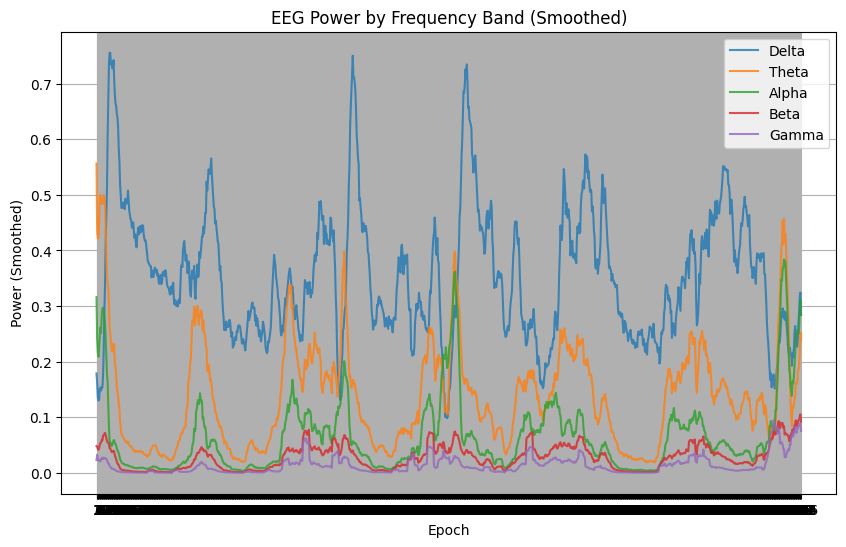

In [20]:
# Make a copy of the DataFrame
df_rolling = eeg_epoch_power_df.copy()

# Apply a rolling average (window size can be adjusted)
window_size = 10
df_rolling[["Delta","Theta","Alpha","Beta","Gamma"]] = (
    df_rolling[["Delta","Theta","Alpha","Beta","Gamma"]]
    .rolling(window_size, min_periods=1)
    .mean()
)

# Plot the smoothed data on a single plot
plt.figure(figsize=(10, 6))
plt.plot(df_rolling["Epoch"], df_rolling["Delta"], label="Delta", alpha=0.8)
plt.plot(df_rolling["Epoch"], df_rolling["Theta"], label="Theta", alpha=0.8)
plt.plot(df_rolling["Epoch"], df_rolling["Alpha"], label="Alpha", alpha=0.8)
plt.plot(df_rolling["Epoch"], df_rolling["Beta"], label="Beta", alpha=0.8)
plt.plot(df_rolling["Epoch"], df_rolling["Gamma"], label="Gamma", alpha=0.8)

plt.xlabel("Epoch")
plt.ylabel("Power (Smoothed)")
plt.title("EEG Power by Frequency Band (Smoothed)")
plt.legend()
plt.grid(True)
plt.show()


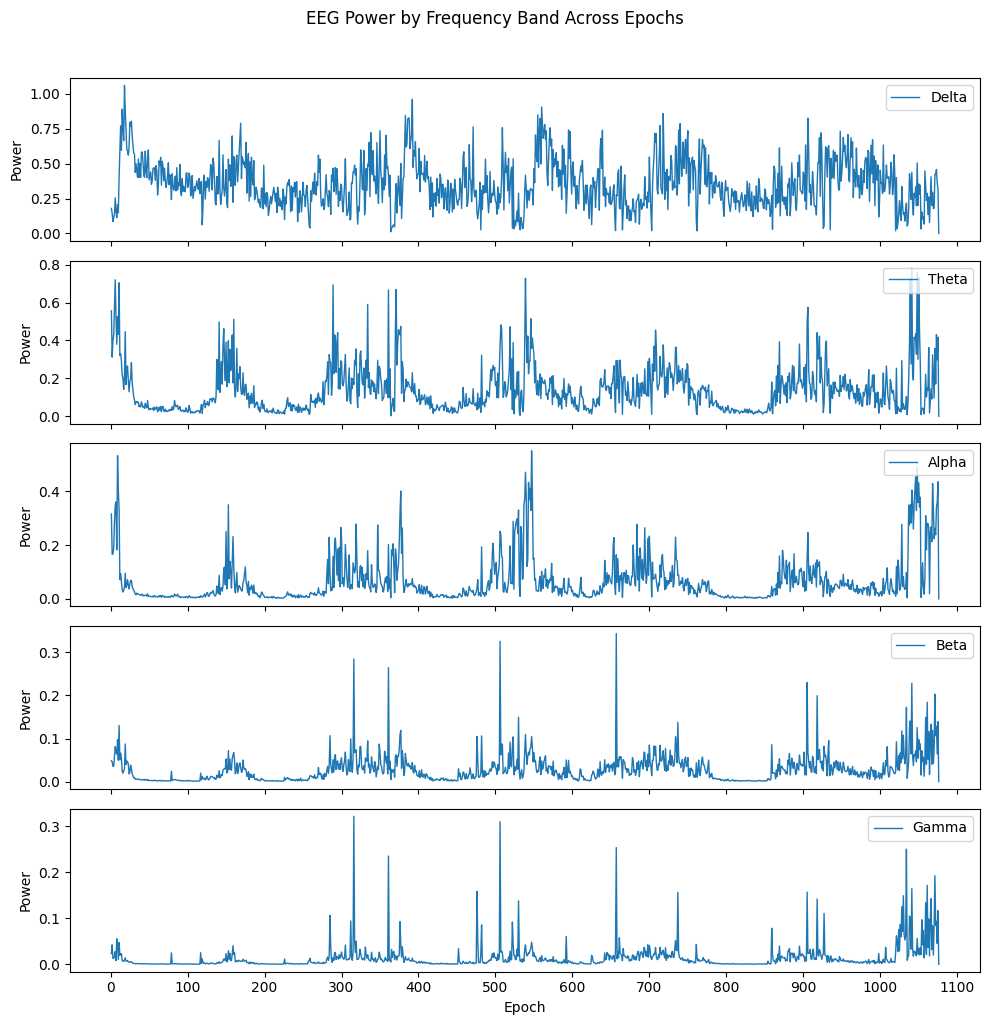

In [21]:
# Convert the Epoch column to integer if it's not already
eeg_epoch_power_df["Epoch"] = eeg_epoch_power_df["Epoch"].astype(int)

bands = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]

fig, axes = plt.subplots(nrows=len(bands), ncols=1, figsize=(10, 10), sharex=True)

for i, band in enumerate(bands):
    axes[i].plot(eeg_epoch_power_df["Epoch"], eeg_epoch_power_df[band], label=band, marker="", linewidth=1.0)
    axes[i].set_ylabel("Power")
    axes[i].legend(loc="upper right")
    # Set major ticks at every 100 epochs
    axes[i].xaxis.set_major_locator(ticker.MultipleLocator(100))

axes[-1].set_xlabel("Epoch")
plt.suptitle("EEG Power by Frequency Band Across Epochs", y=1.02)
plt.tight_layout()
plt.show()



In [22]:
# Load EMG signal from DataFrame
emg_df = df[["EMG Submental_1"]].copy()

# Print first few rows to verify extraction
print(emg_df.head())

   EMG Submental_1
0         4.002038
1         4.003099
2         4.004188
3         4.005303
4         4.006445


In [68]:
# Convert EMG from millivolts (mV) to volts (V)
emg_df["EMG_V"] = emg_df["EMG Submental_1"] * 1e6

# Print first few rows to verify conversion
print(emg_df.head())

   EMG Submental_1         EMG_V  Pseudo_Time   EMG_Scaled      EMG_Raw  \
0         4.002038  4.002038e+06            0  4002.037537  4002.037537   
1         4.003099  4.003099e+06         1000  4003.099405  4003.099405   
2         4.004188  4.004188e+06         2000  4004.187987  4004.187987   
3         4.005303  4.005303e+06         3000  4005.303119  4005.303119   
4         4.006445  4.006445e+06         4000  4006.444636  4006.444636   

   EMG_Clean  EMG_Amplitude  EMG_Activity  EMG_Onsets  EMG_Offsets  
0   0.014395      -0.000049           0.0           0            0  
1  -0.011613      -0.000043           0.0           0            0  
2  -0.019189      -0.000037           0.0           0            0  
3  -0.015748      -0.000032           0.0           0            0  
4  -0.007858      -0.000026           0.0           0            0  


    EMG_Raw  EMG_Clean  EMG_Amplitude  EMG_Activity  EMG_Onsets  EMG_Offsets
0  4.002038   0.000057      -0.000014           0.0           0            0
1  4.062424   0.010991      -0.000012           0.0           0            0
2  4.105674   0.011452      -0.000011           0.0           0            0
3  4.131847   0.006836      -0.000009           0.0           0            0
4  4.141938   0.001280      -0.000008           0.0           0            0
{'EMG_Onsets': array([    207, 3599876]), 'EMG_Offsets': array([259]), 'EMG_Activity': array([207., 208., 209., 210., 211., 212., 213., 214., 215., 216., 217.,
       218., 219., 220., 221., 222., 223., 224., 225., 226., 227., 228.,
       229., 230., 231., 232., 233., 234., 235., 236., 237., 238., 239.,
       240., 241., 242., 243., 244., 245., 246., 247., 248., 249., 250.,
       251., 252., 253., 254., 255., 256., 257., 258.]), 'sampling_rate': 1000}


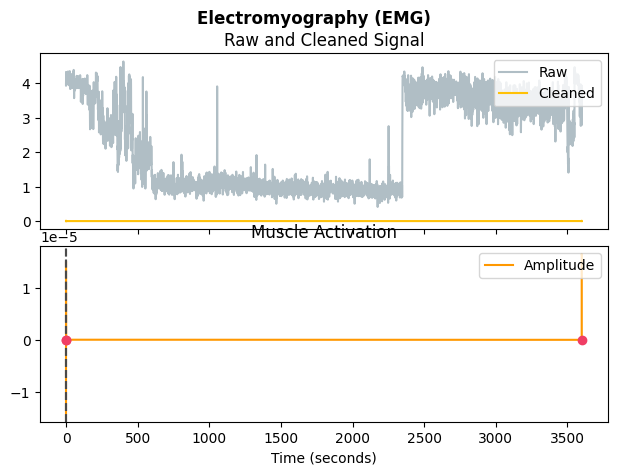

In [85]:
emg_signal = emg_df["EMG Submental_1"]
minutes = 60
#100 samples per second * 60 seconds per minute * num of minutes
num_samples = 100 * 60 * minutes
time_block = emg_signal[:num_samples]

emg_upsampled = sp.signal.resample(time_block, num_samples * 10)
emg_upsampled_processed, upsampled_emg_info = nk.emg_process(emg_upsampled, sampling_rate=1000)

print(emg_upsampled_processed.head())
print(upsampled_emg_info)

nk.emg_plot(emg_upsampled_processed, upsampled_emg_info)

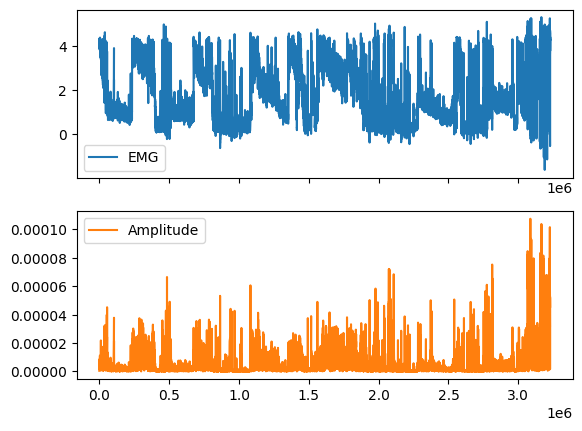

In [73]:
emg_signal = emg_df["EMG Submental_1"]
emg_signal_cleaned = nk.emg_clean(emg_signal, sampling_rate=100, method="none")
emg_amplitude = nk.emg_amplitude(emg_signal_cleaned)
fig = pd.DataFrame({"EMG": emg_signal_cleaned, "Amplitude": emg_amplitude}).plot(subplots=True)

In [55]:
emg_signal = emg_df["EMG Submental_1"]

# Process EMG automatically
emg_processed, emg_info = nk.emg_process(emg_signal, sampling_rate=1000)

# Print processed data
print(emg_processed.head())

# Print extracted event info (onsets, offsets, peaks)
print(emg_info)


    EMG_Raw  EMG_Clean  EMG_Amplitude  EMG_Activity  EMG_Onsets  EMG_Offsets
0  4.002038   0.000014  -4.907376e-11           0.0           0            0
1  4.003099  -0.000012  -4.316235e-11           0.0           0            0
2  4.004188  -0.000019  -3.735706e-11           0.0           0            0
3  4.005303  -0.000016  -3.167625e-11           0.0           0            0
4  4.006445  -0.000008  -2.613710e-11           0.0           0            0
{'EMG_Onsets': array([    206, 3227880]), 'EMG_Offsets': array([264]), 'EMG_Activity': array([206., 207., 208., 209., 210., 211., 212., 213., 214., 215., 216.,
       217., 218., 219., 220., 221., 222., 223., 224., 225., 226., 227.,
       228., 229., 230., 231., 232., 233., 234., 235., 236., 237., 238.,
       239., 240., 241., 242., 243., 244., 245., 246., 247., 248., 249.,
       250., 251., 252., 253., 254., 255., 256., 257., 258., 259., 260.,
       261., 262., 263.]), 'sampling_rate': 1000}


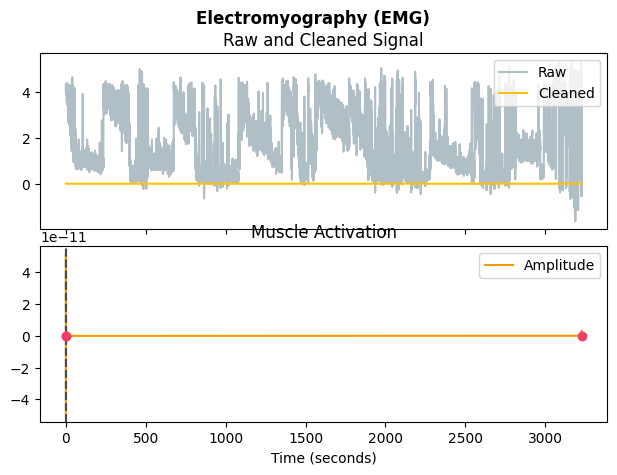

In [ ]:
nk.emg_plot(emg_processed, emg_info)

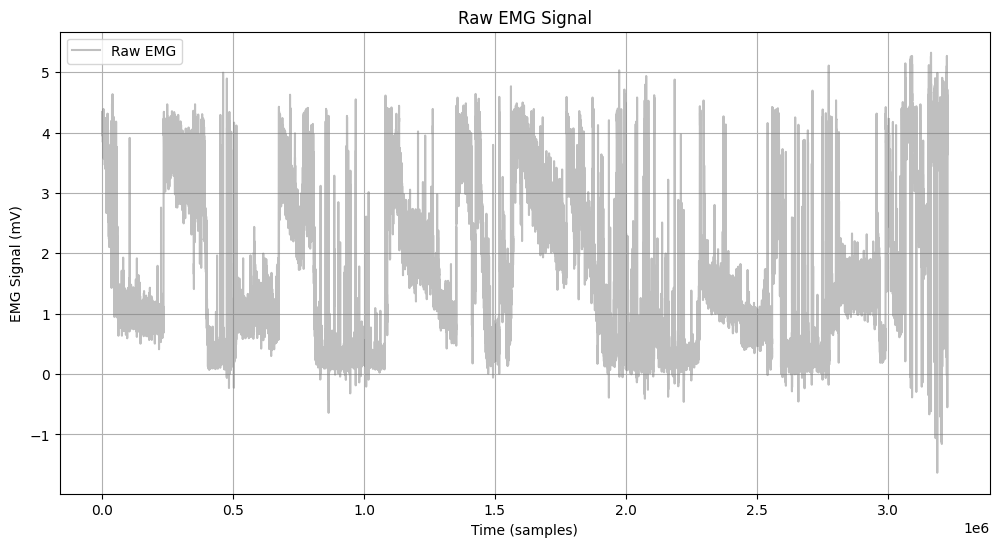

In [ ]:
# Plot raw vs. processed EMG
plt.figure(figsize=(12, 6))
plt.plot(emg_processed.index, emg_processed["EMG_Raw"], label="Raw EMG", alpha=0.5, color="gray")

plt.xlabel("Time (samples)")
plt.ylabel("EMG Signal (mV)")
plt.title("Raw EMG Signal")
plt.legend()
plt.grid()
plt.show()

In [30]:
# Check the time difference between samples

time_diff = np.diff(emg_df.index)  # Difference between timepoints
print("Median Time Difference (s):", np.median(time_diff))
print("Estimated Sampling Rate:", 1 / np.median(time_diff))  # Approximate sampling rate


Median Time Difference (s): 1.0
Estimated Sampling Rate: 1.0


In [31]:
print(emg_df.index[:10])  # Print first few index values

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64', name='Time')


In [32]:
# Generate a proper time index (assuming 1-second intervals)
emg_df["Time"] = np.arange(0, len(emg_df))  # Each row represents 1 second

# Set "Time" as the index
emg_df.set_index("Time", inplace=True)

# Print first few rows to check
print(emg_df.head())


      EMG Submental_1         EMG_V
Time                               
0            4.002038  4.002038e+06
1            4.003099  4.003099e+06
2            4.004188  4.004188e+06
3            4.005303  4.005303e+06
4            4.006445  4.006445e+06


In [33]:
# Compute time differences between consecutive rows
time_diff = np.diff(emg_df.index)

# Print time differences
print("Time Differences Between Samples:", time_diff[:10])

# Compute median sampling interval
median_interval = np.median(time_diff)
print("Median Time Difference (seconds):", median_interval)

# Compute estimated sampling rate
sampling_rate = 1 / median_interval
print("Estimated Sampling Rate (Hz):", sampling_rate)


Time Differences Between Samples: [1 1 1 1 1 1 1 1 1 1]
Median Time Difference (seconds): 1.0
Estimated Sampling Rate (Hz): 1.0


In [34]:
# Create a new pseudo-time axis to simulate 1000 Hz spacing
emg_df["Pseudo_Time"] = emg_df.index * 1000  # Multiply original time by 1000

# Scale feature computations accordingly
emg_df["EMG_Scaled"] = emg_df["EMG Submental_1"] * (1000 / 1)  # Scale values

print(emg_df.head())

      EMG Submental_1         EMG_V  Pseudo_Time   EMG_Scaled
Time                                                         
0            4.002038  4.002038e+06            0  4002.037537
1            4.003099  4.003099e+06         1000  4003.099405
2            4.004188  4.004188e+06         2000  4004.187987
3            4.005303  4.005303e+06         3000  4005.303119
4            4.006445  4.006445e+06         4000  4006.444636


In [35]:
# Create a new DataFrame with Pseudo_Time as the index
pseudo_emg_df = emg_df.copy()
pseudo_emg_df["Time_s"] = pseudo_emg_df["Pseudo_Time"]
pseudo_emg_df.set_index("Time_s", inplace=True)  # Set as index

print(pseudo_emg_df.head())

        EMG Submental_1         EMG_V  Pseudo_Time   EMG_Scaled
Time_s                                                         
0              4.002038  4.002038e+06            0  4002.037537
1000           4.003099  4.003099e+06         1000  4003.099405
2000           4.004188  4.004188e+06         2000  4004.187987
3000           4.005303  4.005303e+06         3000  4005.303119
4000           4.006445  4.006445e+06         4000  4006.444636


In [36]:
emg_signal = pseudo_emg_df["EMG_Scaled"]

pseudo_emg_processed, pseudo_emg_info = nk.emg_process(pseudo_emg_df["EMG_Scaled"], sampling_rate=1000)

# Print first few rows
print(pseudo_emg_df.head())
print(pseudo_emg_info)

        EMG Submental_1         EMG_V  Pseudo_Time   EMG_Scaled
Time_s                                                         
0              4.002038  4.002038e+06            0  4002.037537
1000           4.003099  4.003099e+06         1000  4003.099405
2000           4.004188  4.004188e+06         2000  4004.187987
3000           4.005303  4.005303e+06         3000  4005.303119
4000           4.006445  4.006445e+06         4000  4006.444636
{'EMG_Onsets': array([    206, 3227880]), 'EMG_Offsets': array([264]), 'EMG_Activity': array([206., 207., 208., 209., 210., 211., 212., 213., 214., 215., 216.,
       217., 218., 219., 220., 221., 222., 223., 224., 225., 226., 227.,
       228., 229., 230., 231., 232., 233., 234., 235., 236., 237., 238.,
       239., 240., 241., 242., 243., 244., 245., 246., 247., 248., 249.,
       250., 251., 252., 253., 254., 255., 256., 257., 258., 259., 260.,
       261., 262., 263.]), 'sampling_rate': 1000}


In [37]:
# Process EMG automatically
emg_processed, emg_info = nk.emg_process(emg_df["EMG_Scaled"], sampling_rate=1000)

# Merge processed data back into original DataFrame
emg_df = pd.concat([emg_df, emg_processed], axis=1)

# Print detected muscle activity
print(emg_info)  # Shows onsets, offsets, and detected activity

{'EMG_Onsets': array([    206, 3227880]), 'EMG_Offsets': array([264]), 'EMG_Activity': array([206., 207., 208., 209., 210., 211., 212., 213., 214., 215., 216.,
       217., 218., 219., 220., 221., 222., 223., 224., 225., 226., 227.,
       228., 229., 230., 231., 232., 233., 234., 235., 236., 237., 238.,
       239., 240., 241., 242., 243., 244., 245., 246., 247., 248., 249.,
       250., 251., 252., 253., 254., 255., 256., 257., 258., 259., 260.,
       261., 262., 263.]), 'sampling_rate': 1000}


In [39]:
df2 = pd.read_parquet("data/subj2.parquet")

# Display the first few rows
df2.head()

,EEG Fpz-Cz_2,EEG Pz-Oz_2,EOG horizontal_2,EMG Submental_2,Hyp_2
0,0.000037,0.000018,-0.000107,4.956013,0.0
1,0.000040,0.000013,-0.000119,4.958257,0.0
2,0.000034,0.000011,-0.000117,4.960504,0.0
3,0.000038,-0.000003,-0.000076,4.962752,0.0
4,0.000032,0.000006,-0.000103,4.965000,0.0
